In [1]:
import os 
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display

import tensorflow as tf, gc
from tensorflow import keras
import tensorflow.keras.backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.callbacks import LearningRateScheduler, ReduceLROnPlateau


from sklearn.metrics import mean_absolute_error as mae
from sklearn.preprocessing import RobustScaler, normalize
from sklearn.model_selection import train_test_split, GroupKFold, KFold

%matplotlib inline

In [2]:
class config:
    paths = {
        # data
        'train': '../input/ventilator-pressure-prediction/train.csv',
        'test' : '../input/ventilator-pressure-prediction/test.csv',
        'ss'   : '../input/ventilator-pressure-prediction/sample_submission.csv',    
    }
    
    model_params = {
        'is_train': True,
        'debug'   : False,
        
        'EPOCH'   : 300,
        'BATCH_SIZE' : 1024,
        'NUM_FOLDS' : 10,
    }
    
    post_processing = {
        'max_pressure': 64.82099173863948,
        'min_pressure': -1.8957442945646408,
        'diff_pressure': 0.07030215,
    }

In [3]:
train = pd.read_csv(config.paths["train"])
test = pd.read_csv(config.paths["test"])
submission = pd.read_csv(config.paths["ss"])

if config.model_params["debug"]:
    train = train[:80*1000]
    config.model_params["EPOCH"] = 20
    config.model_params["NUM_FOLDS"] = 5

In [4]:
def add_features(df):
    df['area'] = df['time_step'] * df['u_in']
    df['area'] = df.groupby('breath_id')['area'].cumsum()
    
    df['u_in_cumsum'] = (df['u_in']).groupby(df['breath_id']).cumsum()
    
    df['u_in_lag1'] = df.groupby('breath_id')['u_in'].shift(1)
    df['u_out_lag1'] = df.groupby('breath_id')['u_out'].shift(1)
    df['u_in_lag_back1'] = df.groupby('breath_id')['u_in'].shift(-1)
    df['u_out_lag_back1'] = df.groupby('breath_id')['u_out'].shift(-1)
    df['u_in_lag2'] = df.groupby('breath_id')['u_in'].shift(2)
    df['u_out_lag2'] = df.groupby('breath_id')['u_out'].shift(2)
    df['u_in_lag_back2'] = df.groupby('breath_id')['u_in'].shift(-2)
    df['u_out_lag_back2'] = df.groupby('breath_id')['u_out'].shift(-2)
    df['u_in_lag3'] = df.groupby('breath_id')['u_in'].shift(3)
    df['u_out_lag3'] = df.groupby('breath_id')['u_out'].shift(3)
    df['u_in_lag_back3'] = df.groupby('breath_id')['u_in'].shift(-3)
    df['u_out_lag_back3'] = df.groupby('breath_id')['u_out'].shift(-3)
    df['u_in_lag4'] = df.groupby('breath_id')['u_in'].shift(4)
    df['u_out_lag4'] = df.groupby('breath_id')['u_out'].shift(4)
    df['u_in_lag_back4'] = df.groupby('breath_id')['u_in'].shift(-4)
    df['u_out_lag_back4'] = df.groupby('breath_id')['u_out'].shift(-4)
    df = df.fillna(0)
    
    df['breath_id__u_in__max'] = df.groupby(['breath_id'])['u_in'].transform('max')
    df['breath_id__u_out__max'] = df.groupby(['breath_id'])['u_out'].transform('max')
    
    df['u_in_diff1'] = df['u_in'] - df['u_in_lag1']
    df['u_out_diff1'] = df['u_out'] - df['u_out_lag1']
    df['u_in_diff2'] = df['u_in'] - df['u_in_lag2']
    df['u_out_diff2'] = df['u_out'] - df['u_out_lag2']
    
    df['breath_id__u_in__diffmax'] = df.groupby(['breath_id'])['u_in'].transform('max') - df['u_in']
    df['breath_id__u_in__diffmean'] = df.groupby(['breath_id'])['u_in'].transform('mean') - df['u_in']
    
    df['breath_id__u_in__diffmax'] = df.groupby(['breath_id'])['u_in'].transform('max') - df['u_in']
    df['breath_id__u_in__diffmean'] = df.groupby(['breath_id'])['u_in'].transform('mean') - df['u_in']
    
    df['u_in_diff3'] = df['u_in'] - df['u_in_lag3']
    df['u_out_diff3'] = df['u_out'] - df['u_out_lag3']
    df['u_in_diff4'] = df['u_in'] - df['u_in_lag4']
    df['u_out_diff4'] = df['u_out'] - df['u_out_lag4']
    df['cross']= df['u_in']*(1 - df['u_out'])
    df['cross2']= df['time_step']* (1 - df['u_out'])
    
    df['R'] = df['R'].astype(str)
    df['C'] = df['C'].astype(str)
    df['R__C'] = df["R"].astype(str) + '__' + df["C"].astype(str)
    df = pd.get_dummies(df)
    return df

In [5]:
train = add_features(train)
test = add_features(test)

targets = train[['pressure']].to_numpy().reshape(-1, 80)
train.drop(['pressure', 'id', 'breath_id'], axis=1, inplace=True)
test = test.drop(['id', 'breath_id'], axis=1)

RS = RobustScaler()
train = RS.fit_transform(train)
test = RS.transform(test)

train = train.reshape(-1, 80, train.shape[-1])
test = test.reshape(-1, 80, train.shape[-1])

In [6]:
def create_model(strategy):   
    with strategy.scope():
        model = Sequential([
            keras.layers.Input(shape=train.shape[-2:]),
            keras.layers.Bidirectional(keras.layers.LSTM(1024, return_sequences=True)),
            keras.layers.Bidirectional(keras.layers.LSTM(512, return_sequences=True)),
            keras.layers.Bidirectional(keras.layers.LSTM(256, return_sequences=True)),
            keras.layers.Bidirectional(keras.layers.LSTM(128, return_sequences=True)),
            keras.layers.Dense(128, activation='selu'),
            keras.layers.Dense(1),
        ])

        model.compile(optimizer="adam", loss="mae")
    return model

def plot_hist(hist):
    plt.plot(hist.history["loss"])
    plt.plot(hist.history["val_loss"])
    plt.title("model performance")
    plt.ylabel("mean_absolute_error")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()

In [7]:
# Detect hardware, return appropriate distribution strategy
print(tf.version.VERSION)
try: # detect TPU
    tpu = None
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except ValueError: # detect GPU(s) and enable mixed precision
    strategy = tf.distribute.MirroredStrategy() # works on GPU and multi-GPU
    policy = tf.keras.mixed_precision.experimental.Policy('mixed_float16')
    tf.config.optimizer.set_jit(True) # XLA compilation
    tf.keras.mixed_precision.experimental.set_policy(policy)
    print('Mixed precision enabled')
print("REPLICAS: ", strategy.num_replicas_in_sync)

2.4.1
REPLICAS:  8



FOLD: 0
Epoch 1/300
67/67 [==============================] - 54s 419ms/step - loss: 4.2501 - val_loss: 1.1404
Epoch 2/300
67/67 [==============================] - 9s 141ms/step - loss: 1.0058 - val_loss: 0.7264
Epoch 3/300
67/67 [==============================] - 9s 140ms/step - loss: 0.6840 - val_loss: 0.6937
Epoch 4/300
67/67 [==============================] - 9s 140ms/step - loss: 0.5907 - val_loss: 0.5049
Epoch 5/300
67/67 [==============================] - 9s 140ms/step - loss: 0.5093 - val_loss: 0.4868
Epoch 6/300
67/67 [==============================] - 9s 142ms/step - loss: 0.4758 - val_loss: 0.4370
Epoch 7/300
67/67 [==============================] - 9s 140ms/step - loss: 0.4466 - val_loss: 0.4076
Epoch 8/300
67/67 [==============================] - 9s 141ms/step - loss: 0.4266 - val_loss: 0.4143
Epoch 9/300
67/67 [==============================] - 9s 141ms/step - loss: 0.4032 - val_loss: 0.4258
Epoch 10/300
67/67 [==============================] - 9s 141ms/step - loss: 0.396

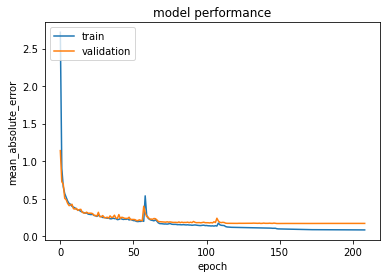


FOLD: 1
Epoch 1/300
67/67 [==============================] - 53s 419ms/step - loss: 3.9258 - val_loss: 1.0444
Epoch 2/300
67/67 [==============================] - 10s 143ms/step - loss: 0.9063 - val_loss: 0.6590
Epoch 3/300
67/67 [==============================] - 10s 143ms/step - loss: 0.6674 - val_loss: 0.7698
Epoch 4/300
67/67 [==============================] - 9s 142ms/step - loss: 0.6320 - val_loss: 0.5325
Epoch 5/300
67/67 [==============================] - 10s 144ms/step - loss: 0.5228 - val_loss: 0.4800
Epoch 6/300
67/67 [==============================] - 10s 143ms/step - loss: 0.4659 - val_loss: 0.4078
Epoch 7/300
67/67 [==============================] - 10s 143ms/step - loss: 0.4230 - val_loss: 0.4228
Epoch 8/300
67/67 [==============================] - 10s 142ms/step - loss: 0.4072 - val_loss: 0.4082
Epoch 9/300
67/67 [==============================] - 9s 141ms/step - loss: 0.4152 - val_loss: 0.3807
Epoch 10/300
67/67 [==============================] - 9s 141ms/step - loss:

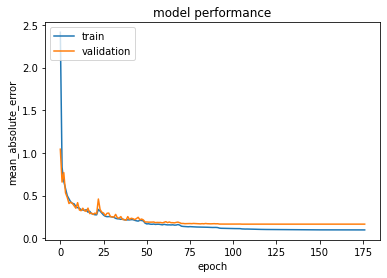


FOLD: 2
Epoch 1/300
67/67 [==============================] - 55s 423ms/step - loss: 4.0421 - val_loss: 1.0847
Epoch 2/300
67/67 [==============================] - 10s 142ms/step - loss: 0.9632 - val_loss: 0.8262
Epoch 3/300
67/67 [==============================] - 10s 143ms/step - loss: 0.6998 - val_loss: 0.6773
Epoch 4/300
67/67 [==============================] - 9s 142ms/step - loss: 0.5716 - val_loss: 0.6762
Epoch 5/300
67/67 [==============================] - 9s 142ms/step - loss: 0.5416 - val_loss: 0.5439
Epoch 6/300
67/67 [==============================] - 9s 141ms/step - loss: 0.4966 - val_loss: 0.4379
Epoch 7/300
67/67 [==============================] - 9s 141ms/step - loss: 0.4382 - val_loss: 0.4165
Epoch 8/300
67/67 [==============================] - 9s 142ms/step - loss: 0.4222 - val_loss: 0.3974
Epoch 9/300
67/67 [==============================] - 10s 142ms/step - loss: 0.3957 - val_loss: 0.4455
Epoch 10/300
67/67 [==============================] - 9s 142ms/step - loss: 0.

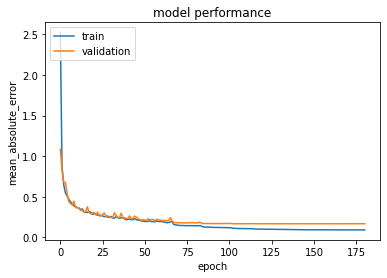


FOLD: 3
Epoch 1/300
67/67 [==============================] - 54s 434ms/step - loss: 3.8437 - val_loss: 1.1872
Epoch 2/300
67/67 [==============================] - 9s 141ms/step - loss: 0.9965 - val_loss: 0.8055
Epoch 3/300
67/67 [==============================] - 9s 142ms/step - loss: 0.6915 - val_loss: 0.5938
Epoch 4/300
67/67 [==============================] - 9s 142ms/step - loss: 0.5939 - val_loss: 0.4980
Epoch 5/300
67/67 [==============================] - 9s 141ms/step - loss: 0.5296 - val_loss: 0.4722
Epoch 6/300
67/67 [==============================] - 9s 141ms/step - loss: 0.4627 - val_loss: 0.4441
Epoch 7/300
67/67 [==============================] - 9s 141ms/step - loss: 0.4316 - val_loss: 0.4445
Epoch 8/300
67/67 [==============================] - 9s 142ms/step - loss: 0.4237 - val_loss: 0.4465
Epoch 9/300
67/67 [==============================] - 9s 141ms/step - loss: 0.4227 - val_loss: 0.3814
Epoch 10/300
67/67 [==============================] - 10s 142ms/step - loss: 0.37

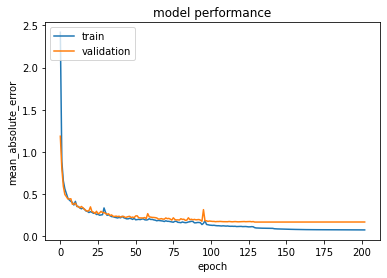


FOLD: 4
Epoch 1/300
67/67 [==============================] - 54s 424ms/step - loss: 3.7859 - val_loss: 1.0795
Epoch 2/300
67/67 [==============================] - 9s 142ms/step - loss: 0.9513 - val_loss: 0.7574
Epoch 3/300
67/67 [==============================] - 10s 142ms/step - loss: 0.7421 - val_loss: 0.5711
Epoch 4/300
67/67 [==============================] - 9s 142ms/step - loss: 0.5691 - val_loss: 0.5089
Epoch 5/300
67/67 [==============================] - 9s 141ms/step - loss: 0.5019 - val_loss: 0.4635
Epoch 6/300
67/67 [==============================] - 9s 141ms/step - loss: 0.4688 - val_loss: 0.4384
Epoch 7/300
67/67 [==============================] - 9s 141ms/step - loss: 0.4337 - val_loss: 0.3993
Epoch 8/300
67/67 [==============================] - 9s 141ms/step - loss: 0.4098 - val_loss: 0.4291
Epoch 9/300
67/67 [==============================] - 9s 141ms/step - loss: 0.4020 - val_loss: 0.4282
Epoch 10/300
67/67 [==============================] - 9s 141ms/step - loss: 0.38

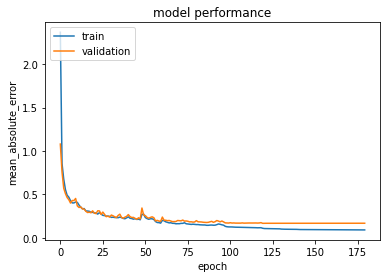


FOLD: 5
Epoch 1/300
67/67 [==============================] - 56s 438ms/step - loss: 3.8877 - val_loss: 1.0397
Epoch 2/300
67/67 [==============================] - 10s 143ms/step - loss: 0.9903 - val_loss: 0.7325
Epoch 3/300
67/67 [==============================] - 9s 142ms/step - loss: 0.6790 - val_loss: 0.5547
Epoch 4/300
67/67 [==============================] - 9s 141ms/step - loss: 0.6209 - val_loss: 0.5151
Epoch 5/300
67/67 [==============================] - 10s 142ms/step - loss: 0.5229 - val_loss: 0.4826
Epoch 6/300
67/67 [==============================] - 9s 141ms/step - loss: 0.4929 - val_loss: 0.4330
Epoch 7/300
67/67 [==============================] - 9s 142ms/step - loss: 0.4428 - val_loss: 0.4109
Epoch 8/300
67/67 [==============================] - 9s 142ms/step - loss: 0.4114 - val_loss: 0.3966
Epoch 9/300
67/67 [==============================] - 9s 141ms/step - loss: 0.3942 - val_loss: 0.4881
Epoch 10/300
67/67 [==============================] - 10s 142ms/step - loss: 0.

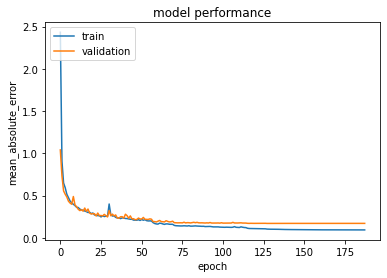


FOLD: 6
Epoch 1/300
67/67 [==============================] - 56s 445ms/step - loss: 3.8846 - val_loss: 1.0854
Epoch 2/300
67/67 [==============================] - 9s 141ms/step - loss: 0.9807 - val_loss: 0.7974
Epoch 3/300
67/67 [==============================] - 9s 141ms/step - loss: 0.7327 - val_loss: 0.6301
Epoch 4/300
67/67 [==============================] - 9s 142ms/step - loss: 0.5685 - val_loss: 0.5390
Epoch 5/300
67/67 [==============================] - 9s 141ms/step - loss: 0.5222 - val_loss: 0.4819
Epoch 6/300
67/67 [==============================] - 9s 141ms/step - loss: 0.4622 - val_loss: 0.4362
Epoch 7/300
67/67 [==============================] - 10s 144ms/step - loss: 0.4482 - val_loss: 0.4201
Epoch 8/300
67/67 [==============================] - 9s 141ms/step - loss: 0.4137 - val_loss: 0.4195
Epoch 9/300
67/67 [==============================] - 9s 141ms/step - loss: 0.3972 - val_loss: 0.3821
Epoch 10/300
67/67 [==============================] - 9s 142ms/step - loss: 0.38

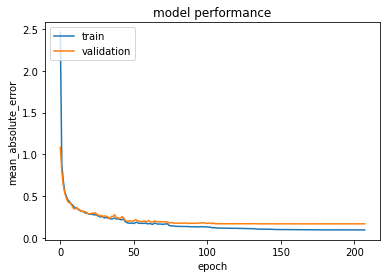


FOLD: 7
Epoch 1/300
67/67 [==============================] - 56s 447ms/step - loss: 3.9554 - val_loss: 1.0469
Epoch 2/300
67/67 [==============================] - 9s 141ms/step - loss: 0.9649 - val_loss: 0.7188
Epoch 3/300
67/67 [==============================] - 9s 142ms/step - loss: 0.6902 - val_loss: 0.5976
Epoch 4/300
67/67 [==============================] - 10s 143ms/step - loss: 0.5706 - val_loss: 0.5780
Epoch 5/300
67/67 [==============================] - 9s 142ms/step - loss: 0.5588 - val_loss: 0.4912
Epoch 6/300
67/67 [==============================] - 9s 142ms/step - loss: 0.4669 - val_loss: 0.4405
Epoch 7/300
67/67 [==============================] - 9s 141ms/step - loss: 0.4370 - val_loss: 0.4303
Epoch 8/300
67/67 [==============================] - 9s 142ms/step - loss: 0.4300 - val_loss: 0.4618
Epoch 9/300
67/67 [==============================] - 9s 141ms/step - loss: 0.4123 - val_loss: 0.3821
Epoch 10/300
67/67 [==============================] - 9s 141ms/step - loss: 0.37

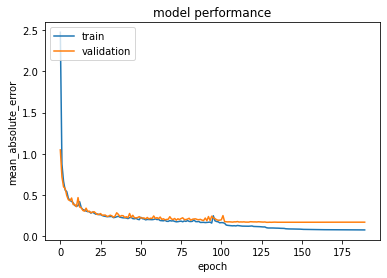


FOLD: 8
Epoch 1/300
67/67 [==============================] - 56s 434ms/step - loss: 4.2583 - val_loss: 1.2507
Epoch 2/300
67/67 [==============================] - 9s 141ms/step - loss: 1.0269 - val_loss: 0.7268
Epoch 3/300
67/67 [==============================] - 9s 141ms/step - loss: 0.6927 - val_loss: 0.6089
Epoch 4/300
67/67 [==============================] - 9s 142ms/step - loss: 0.5853 - val_loss: 0.5160
Epoch 5/300
67/67 [==============================] - 9s 142ms/step - loss: 0.5158 - val_loss: 0.5269
Epoch 6/300
67/67 [==============================] - 9s 142ms/step - loss: 0.5112 - val_loss: 0.4671
Epoch 7/300
67/67 [==============================] - 9s 141ms/step - loss: 0.4357 - val_loss: 0.5067
Epoch 8/300
67/67 [==============================] - 9s 141ms/step - loss: 0.4415 - val_loss: 0.4056
Epoch 9/300
67/67 [==============================] - 9s 142ms/step - loss: 0.3990 - val_loss: 0.4016
Epoch 10/300
67/67 [==============================] - 9s 142ms/step - loss: 0.384

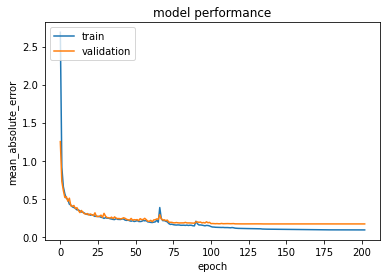


FOLD: 9
Epoch 1/300
67/67 [==============================] - 57s 443ms/step - loss: 3.9874 - val_loss: 1.0005
Epoch 2/300
67/67 [==============================] - 10s 155ms/step - loss: 0.9620 - val_loss: 0.8680
Epoch 3/300
67/67 [==============================] - 10s 143ms/step - loss: 0.7425 - val_loss: 0.5878
Epoch 4/300
67/67 [==============================] - 9s 142ms/step - loss: 0.5746 - val_loss: 0.5008
Epoch 5/300
67/67 [==============================] - 10s 142ms/step - loss: 0.4913 - val_loss: 0.4474
Epoch 6/300
67/67 [==============================] - 10s 142ms/step - loss: 0.4586 - val_loss: 0.4673
Epoch 7/300
67/67 [==============================] - 9s 142ms/step - loss: 0.4381 - val_loss: 0.4194
Epoch 8/300
67/67 [==============================] - 10s 143ms/step - loss: 0.4048 - val_loss: 0.3888
Epoch 9/300
67/67 [==============================] - 10s 143ms/step - loss: 0.3932 - val_loss: 0.3775
Epoch 10/300
67/67 [==============================] - 10s 142ms/step - loss

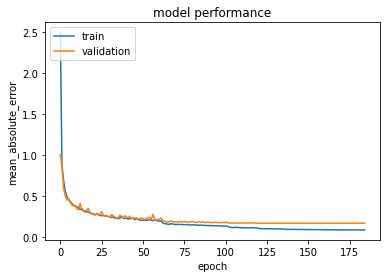

In [8]:
kf = KFold(n_splits=config.model_params["NUM_FOLDS"], shuffle=True, random_state=2021)
test_preds = []

for fold, (train_idx, test_idx) in enumerate(kf.split(train, targets)):
    K.clear_session()
    print(f"\nFOLD: {fold}")
    X_train, X_valid = train[train_idx], train[test_idx]
    y_train, y_valid = targets[train_idx], targets[test_idx]
    
    checkpoint_filepath = f"./folds_{fold}.hdf5"
    lr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=10, verbose=0)
    es = EarlyStopping(monitor="val_loss", patience=60, verbose=0, mode="min", restore_best_weights=True)
    sv = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor='val_loss',
        verbose=0, 
        save_best_only=True,
        save_weights_only=False,
        mode='auto',
        save_freq='epoch'
    )
    
    model = create_model(strategy)
        
    history = model.fit(X_train, y_train,
                        validation_data=(X_valid, y_valid),
                        epochs=config.model_params["EPOCH"],
                        batch_size=config.model_params["BATCH_SIZE"], 
                        callbacks = [lr, es, sv])
    
    test_preds.append(model.predict(test, batch_size=config.model_params["BATCH_SIZE"], verbose=1).squeeze().reshape(-1, 1).squeeze())
    plot_hist(history)
    del X_train, X_valid, y_train, y_valid, model
    gc.collect()

In [9]:
submission["pressure"] = np.median(np.vstack(test_preds), axis=0)
submission["pressure"] = np.round((submission.pressure - config.post_processing["min_pressure"])/config.post_processing["diff_pressure"]) * config.post_processing["diff_pressure"] + config.post_processing["min_pressure"]
submission.pressure = np.clip(submission.pressure, config.post_processing["min_pressure"], config.post_processing["max_pressure"])
display(submission.head())
submission.to_csv('submission_median_round_LB153.csv', index=False)

,id,pressure
0,1,6.259305
1,2,5.978097
2,3,7.102931
3,4,7.665348
4,5,9.071391


EOF!